# Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.genmod.cov_struct as smcs
import statsmodels.formula.api as smf
from IPython.display import HTML, display

# Stats
from scipy import stats

# Some constants
data_file = 'https://raw.githubusercontent.com/hieubkvn123/MH6321-project/main/data/full-data.csv'

# Load data

In [2]:
df_full = pd.read_csv(data_file)

In [68]:
### Some constants ###
alpha = 0.001

### Utility functions ###
def _pvalue_table_cell_styler(val):
    default_style = 'border : 1px solid black;'
    if(float(val) < alpha):
        return default_style + 'background-color: red; color: black'
    elif(float(val) == 1.0):
        return default_style + 'background-color: grey'
    elif(str(val) == 'nan'):
        return default_style + 'background-color: black'
    else:
        return default_style + 'background-color: green'

### Columns and mappings ###
heart_diseases = [
    'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP'
]

disease_dict = {
    'PREVAP' : 'Angina Pectoris',
    'PREVMI' : 'Myocardial Infarction',
    'PREVSTRK' : 'Stroke',
    'PREVHYP' : 'Hypertensive'
}

cardiovascular_risks = [
    'TOTCHOL', 'SYSBP', 'DIABP', # Cholesterol + Blood pressure
    'CIGPDAY', # Smoking habits
    'BMI', 'GLUCOSE', # Fat people
]

risk_dict = {
    'TOTCHOL' : 'Serum cholesterol',
    'SYSBP' : 'Systolic blood pressure',
    'DIABP' : 'Diastolic blood pressure',
    'CIGPDAY' : 'Cigarettes per day',
    'BMI' : 'Body mass index',
    'GLUCOSE' : 'Casual glucose'
}

# I. Age versus cardiovascular risks

## 1. Divide the data into age groups

In [4]:
age_bins = [35, 45, 55, 65, 75, 85]
age_labels = ['35-44', '44-54', '55-64', '65-74', '75-84']
df_full['AGEGROUP'] = pd.cut(df_full['AGE'], bins=age_bins, labels=age_labels, right=False)

In [5]:
df_full.head(5)

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP,AGEGROUP
0,2448,1,195.0,39,106.0,70.0,0,0.0,26.97,0,...,0,8766,6438,6438,6438,8766,6438,8766,8766,35-44
1,2448,1,209.0,52,121.0,66.0,0,0.0,NaN,0,...,0,8766,6438,6438,6438,8766,6438,8766,8766,44-54
2,6238,2,250.0,46,121.0,81.0,0,0.0,28.73,0,...,0,8766,8766,8766,8766,8766,8766,8766,8766,44-54
3,6238,2,260.0,52,105.0,69.5,0,0.0,29.43,0,...,0,8766,8766,8766,8766,8766,8766,8766,8766,44-54
4,6238,2,237.0,58,108.0,66.0,0,0.0,28.50,0,...,0,8766,8766,8766,8766,8766,8766,8766,8766,55-64


## 2. Visualize cardiovascular risks of different age groups
- Among people with cardiovascular diseases, is there a significant difference in cardiovascular risks across different age groups? For example, among people with hypertension, is there a significant difference in the bmi of people from 35-44 and people from 55-64 years of age?

- For each age group, is there a significant difference in the intensity of cardiovascular risks between non-prevalent and prevalent heart disease? For example, among people from 35-44 years of age, is there a difference in the level of cholesterol between people with Angina Pectoris and people who do not have AP?

### 2.1. Initial visualizations

In [37]:
pvalues, statistics = [], []
for disease in heart_diseases:
    # Construct the contigency table
    cont_table = pd.crosstab(index=df_full['AGEGROUP'], columns=df_full[disease])

    # Conduct the chi-square test
    statistic, pvalue, _, _ = stats.chi2_contingency(cont_table.values)
    statistics.append(statistic)
    pvalues.append(pvalue)

    # Report
    print('\n[INFO] Contigency test for ', disease_dict[disease])
    display(cont_table)
    print(f' - Chi-square statistic : {statistic}')
    print(f' - p-value : {pvalue}')

print(pd.DataFrame(
    {
        'Disease' : heart_diseases,
        '\chi^2-statistics' : statistics,
        'P-values' : pvalues
    }
).to_latex())


[INFO] Contigency test for  Angina Pectoris


PREVAP,0,1
AGEGROUP,,
35-44,1775,10
44-54,4002,93
55-64,3449,252
65-74,1575,244
75-84,175,28


 - Chi-square statistic : 431.1070469909537
 - p-value : 5.270592571024635e-92

[INFO] Contigency test for  Myocardial Infarction


PREVMI,0,1
AGEGROUP,,
35-44,1773,12
44-54,4011,84
55-64,3559,142
65-74,1696,123
75-84,190,13


 - Chi-square statistic : 139.33953699826523
 - p-value : 3.9087478376841707e-29

[INFO] Contigency test for  Stroke


PREVSTRK,0,1
AGEGROUP,,
35-44,1780,5
44-54,4074,21
55-64,3648,53
65-74,1758,61
75-84,191,12


 - Chi-square statistic : 127.19715279711943
 - p-value : 1.547790442059569e-26

[INFO] Contigency test for  Hypertensive


PREVHYP,0,1
AGEGROUP,,
35-44,1469,316
44-54,2563,1532
55-64,1673,2028
65-74,516,1303
75-84,39,164


 - Chi-square statistic : 1392.0872694879038
 - p-value : 3.592115004292607e-300
\begin{tabular}{llrr}
\toprule
 & Disease & \chi^2-statistics & P-values \\
\midrule
0 & PREVAP & 431.107047 & 0.000000 \\
1 & PREVMI & 139.339537 & 0.000000 \\
2 & PREVSTRK & 127.197153 & 0.000000 \\
3 & PREVHYP & 1392.087269 & 0.000000 \\
\bottomrule
\end{tabular}



C:\Users\mnong\AppData\Local\Temp\ipykernel_9156\3196328468.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


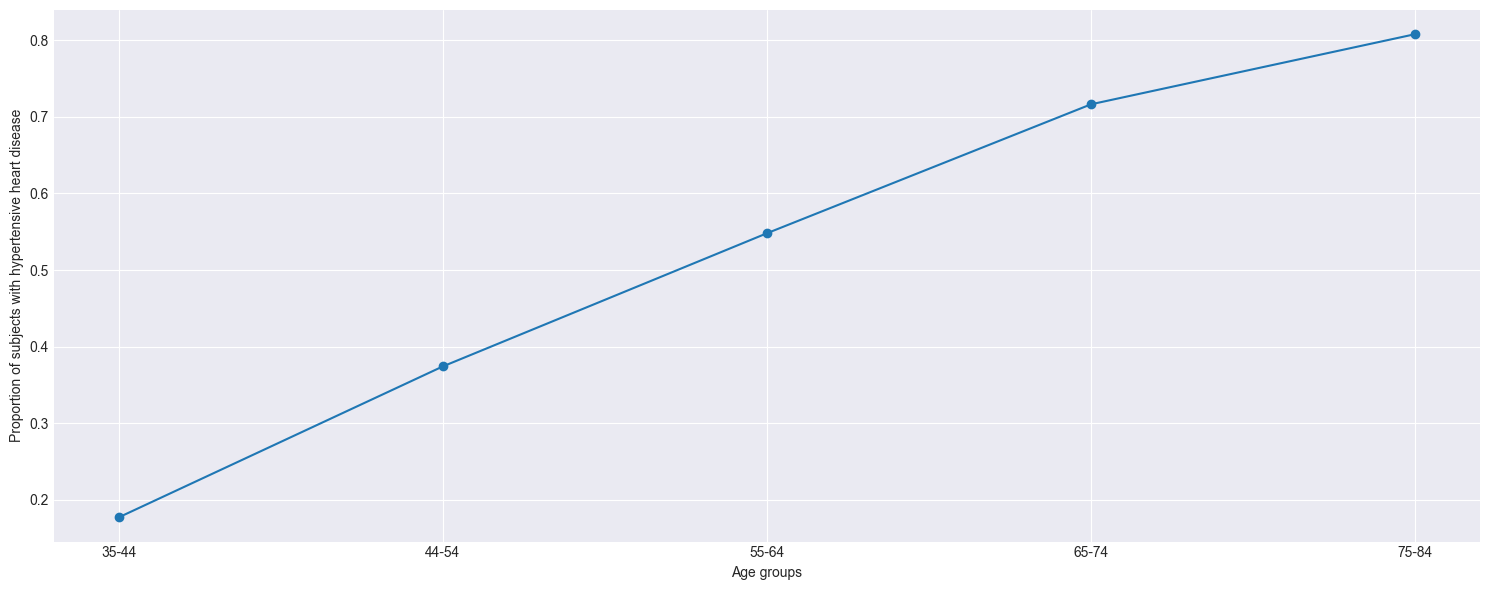

In [48]:
# Visualize prevalence ratio of hypertensive heart disease by ages
fig, ax = plt.subplots(figsize=(15, 6))
cont_table = pd.crosstab(index=df_full['AGEGROUP'], columns=df_full['PREVHYP'])
prev_ratio = cont_table[1] / (cont_table[1] + cont_table[0])

plt.style.use('seaborn-dark')
plt.plot(age_labels, prev_ratio, marker='o')
plt.xlabel('Age groups')
plt.ylabel('Proportion of subjects with hypertensive heart disease')
plt.tight_layout()
plt.grid()
plt.show()


[INFO] VISUALIZATION FOR : ANGINA PECTORIS


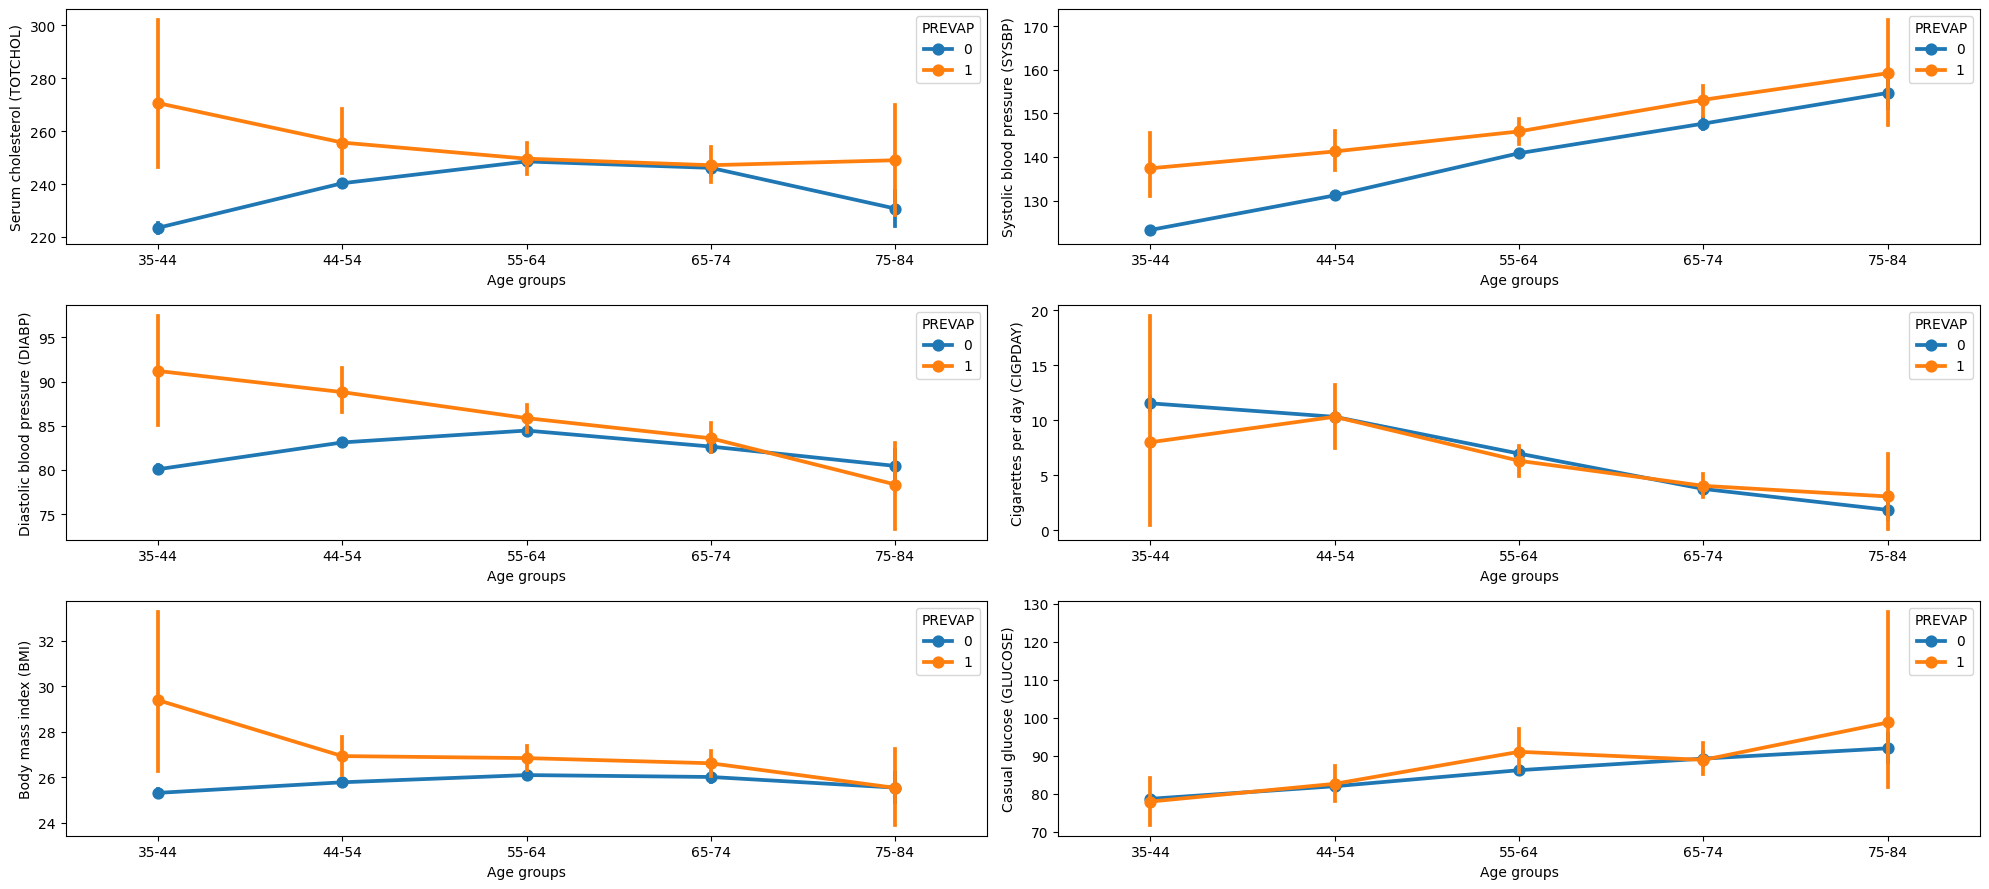


[INFO] VISUALIZATION FOR : MYOCARDIAL INFARCTION


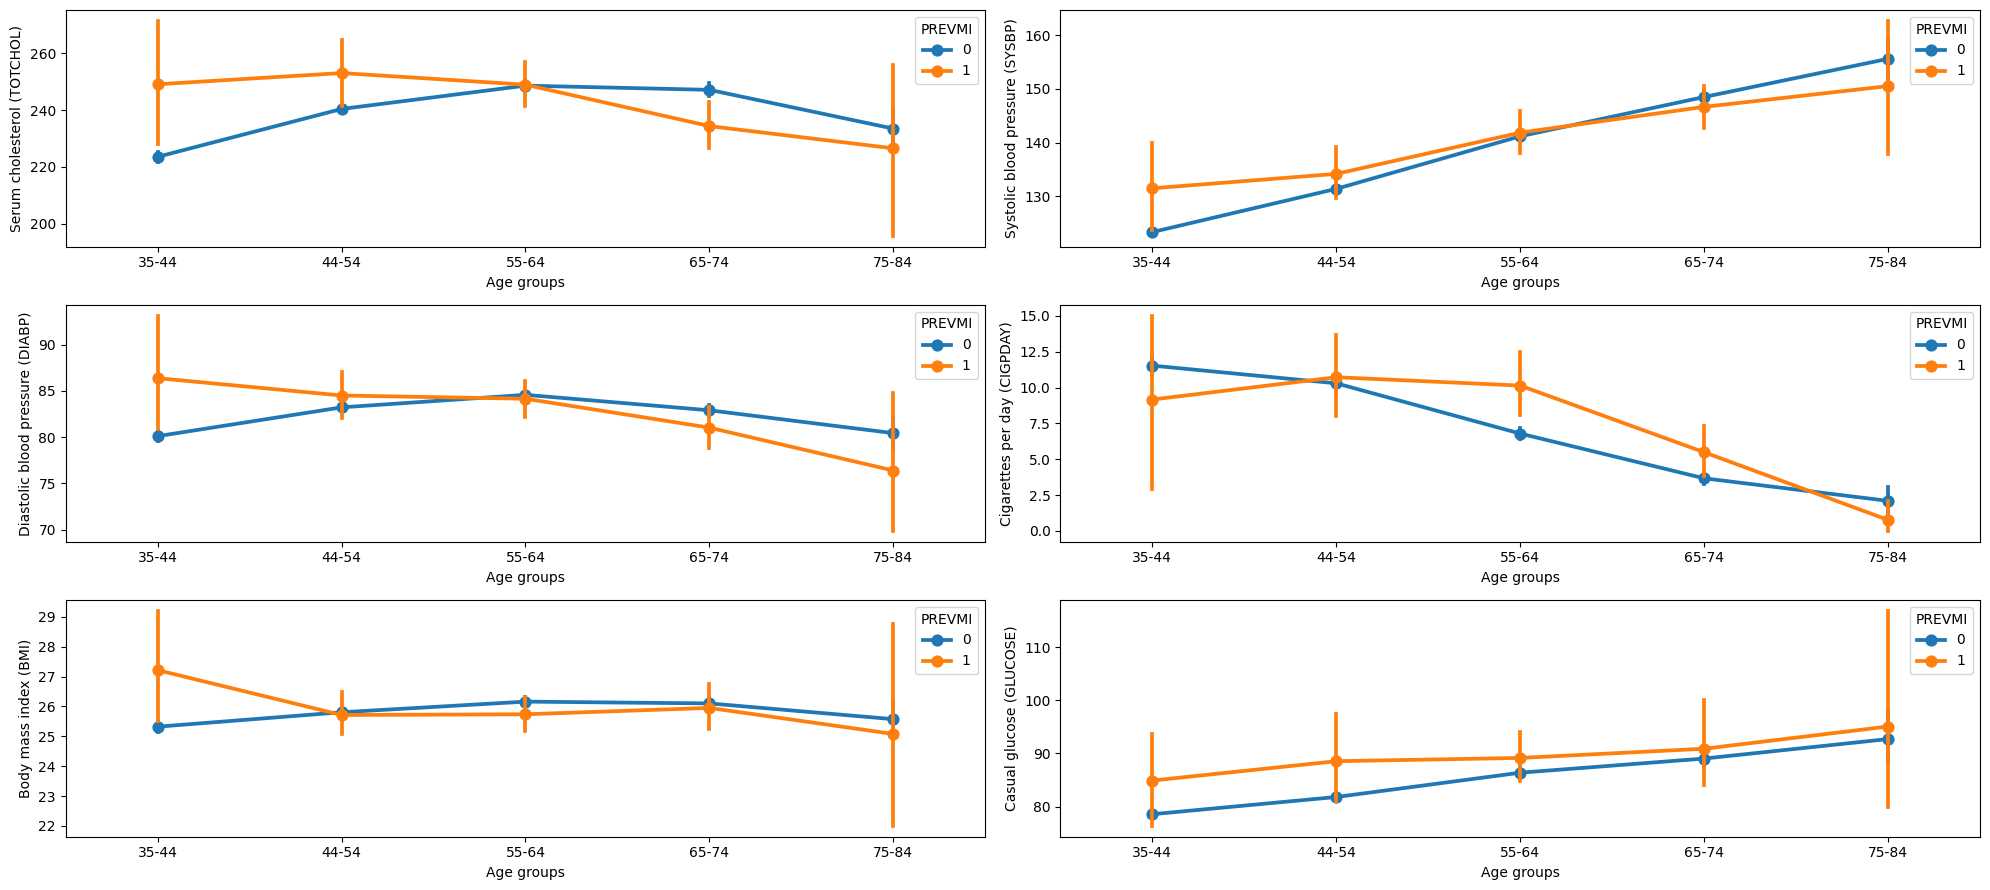


[INFO] VISUALIZATION FOR : STROKE


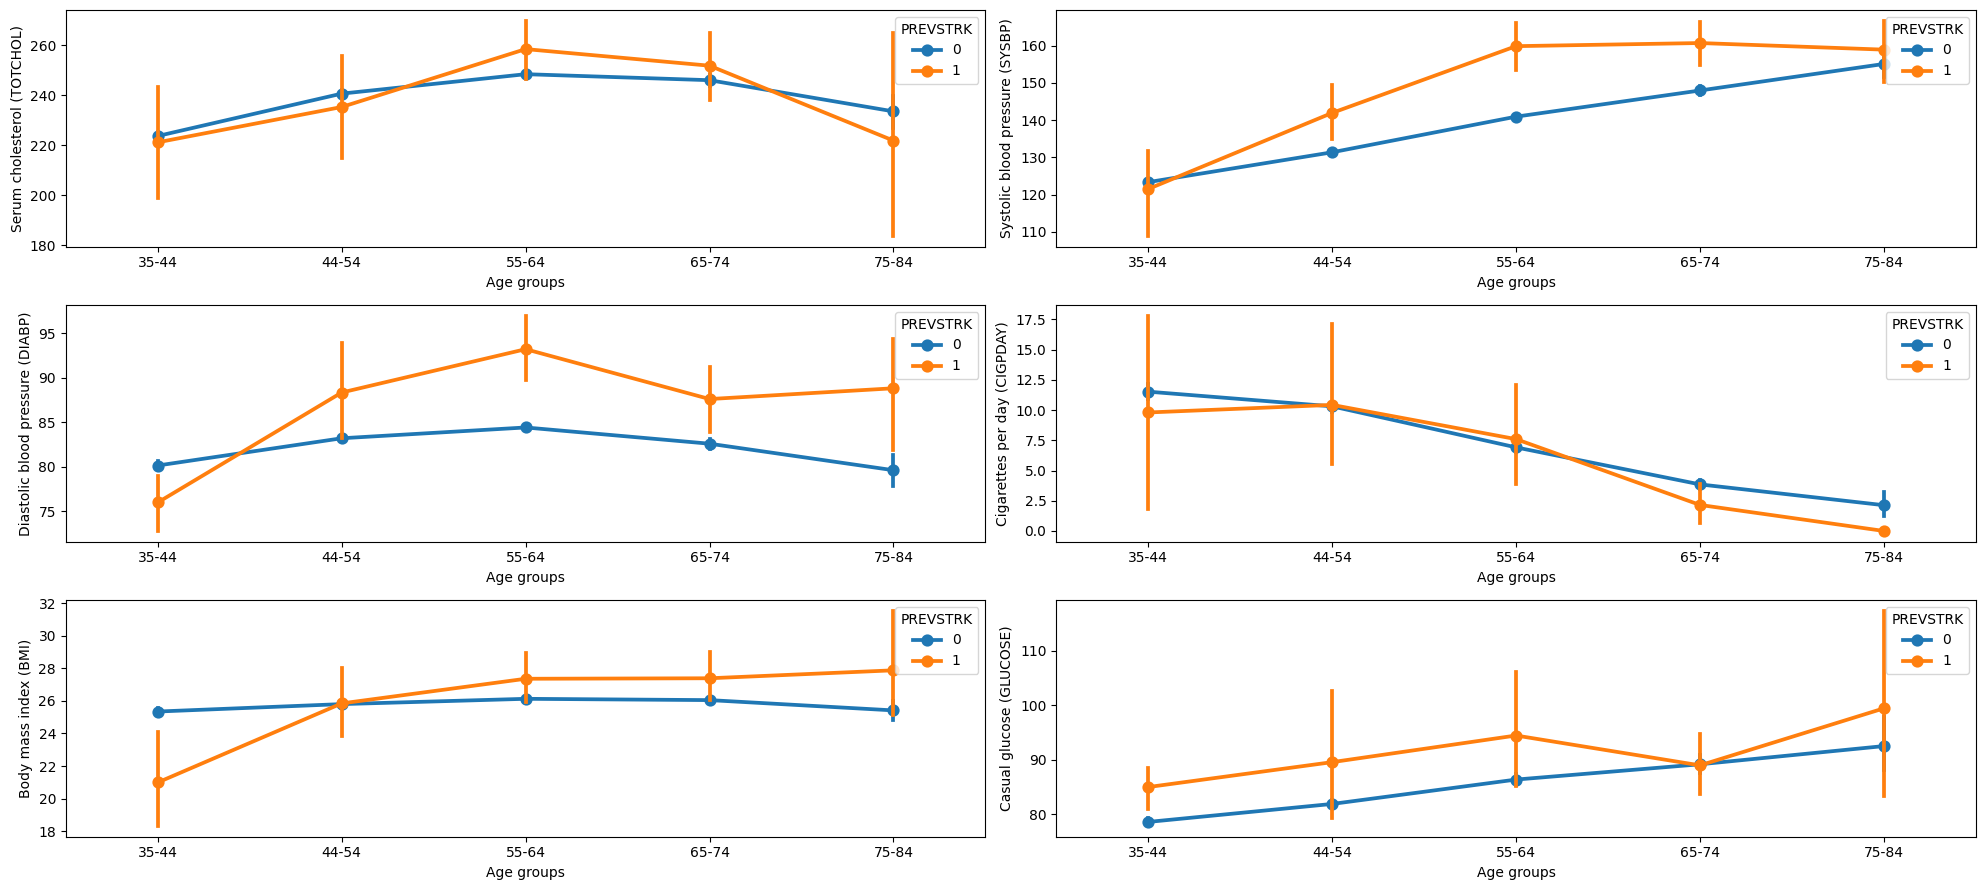


[INFO] VISUALIZATION FOR : HYPERTENSIVE


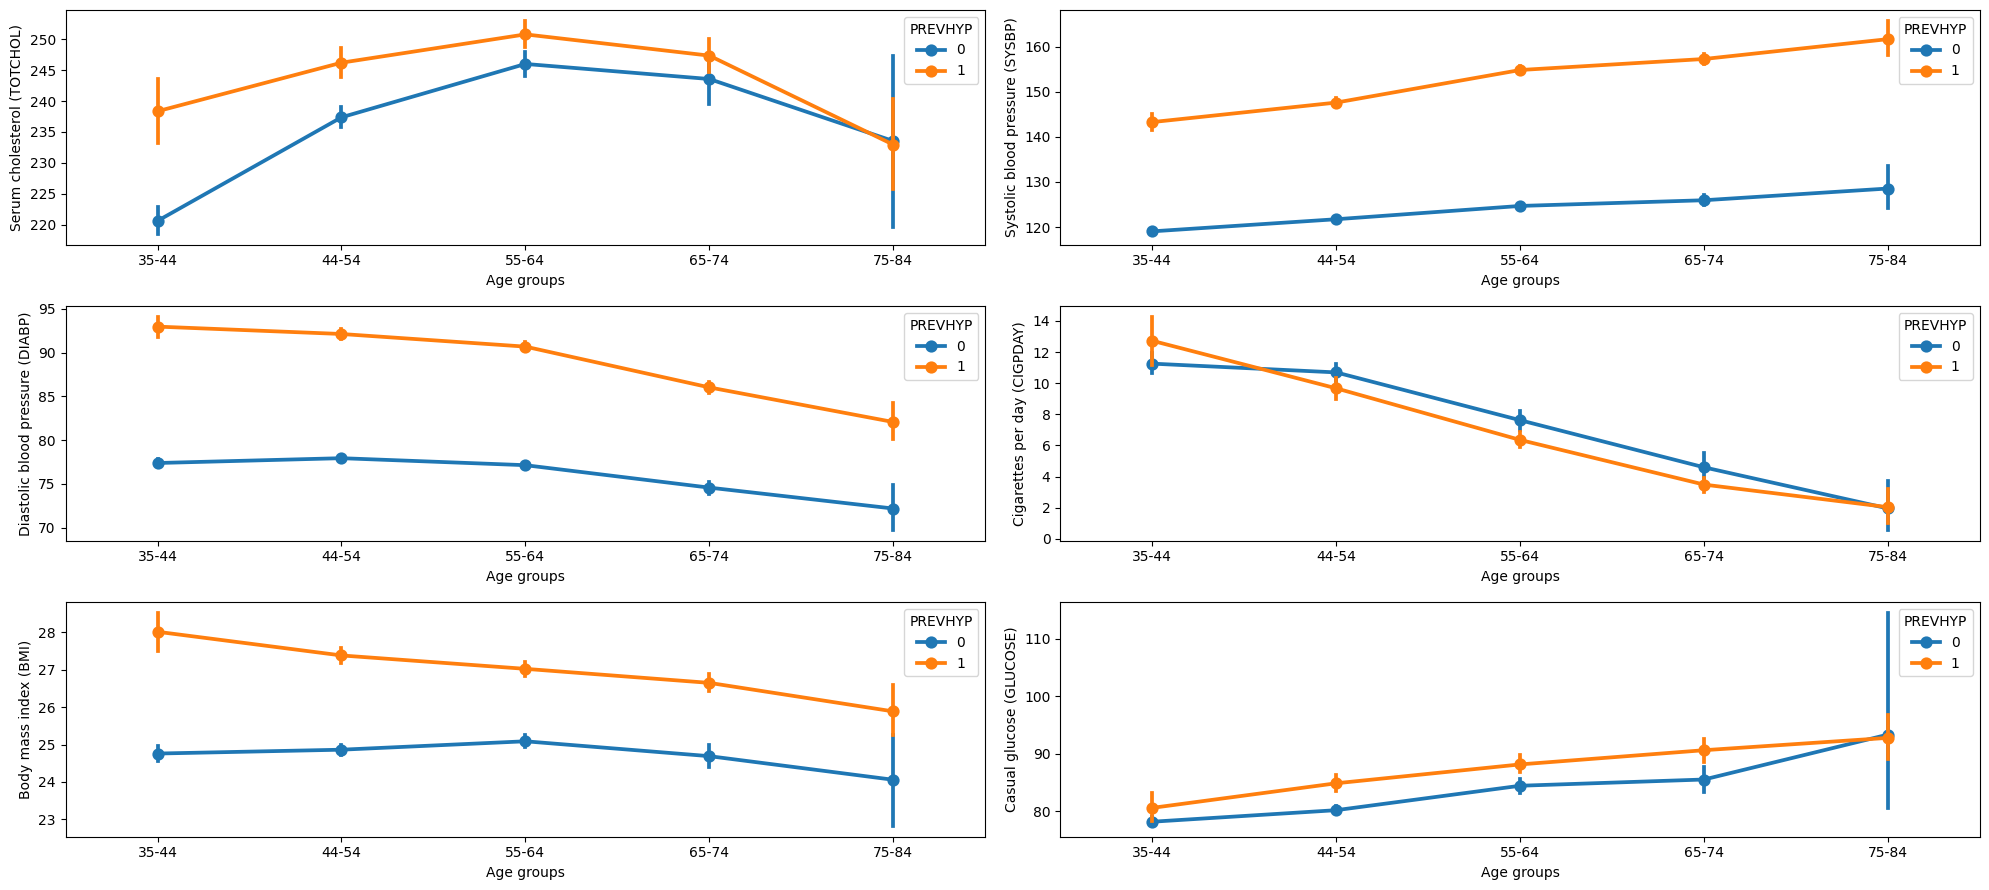

In [6]:
def visualize_cardiovascular_risks(disease):
  print(f'[INFO] VISUALIZATION FOR : {disease_dict[disease].upper()}')
  _, axes = plt.subplots(3,2, figsize=(20, 9))

  for i, risk in enumerate(cardiovascular_risks):
    row = i // 2
    col = i  % 2
    axes[row][col] = sns.pointplot(data=df_full, y=risk, x='AGEGROUP', hue=disease,ax=axes[row][col])
    axes[row][col].set_ylabel(f'{risk_dict[risk]} ({risk})')
    axes[row][col].set_xlabel('Age groups')
  plt.tight_layout()
  plt.show()

for disease in heart_diseases:
  visualize_cardiovascular_risks(disease)
  print('=' * 150 + '\n')

### 2.2. How cardiovascular risks vary with age
- For every cardiovascular disease, an one-way ANOVA test will be conducted for each risk factor to identify if certain risk factors that varies significantly with respect to age.
- Upon identifying these factors, it answers the question "When diagnosing a subject for a certain heart disease, which factors are age-dependent".

In [7]:
def oneway_f_test(disease, risk):
  # Get subjects with corresponding disease
  df_disease = df_full[df_full[disease] == 1]

  # Remove subjects with empty risk factor
  df_disease = df_disease[~df_disease[risk].isna()]

  # Oneway F-test for the groups
  groups = [df_disease[df_disease['AGEGROUP'] == group][risk].values for group in age_labels]
  results = stats.f_oneway(*groups)

  return results.statistic, results.pvalue

results = {}
statistics = {}
for disease in heart_diseases:
  results[disease], statistics[disease] = [], []
  for risk in cardiovascular_risks:
    F, pvalue = oneway_f_test(disease, risk)
    
    results[disease].append(pvalue)
    statistics[disease].append(F)

statistics = pd.DataFrame(statistics)
results = pd.DataFrame(results, index=cardiovascular_risks)
results = results.style.applymap(_pvalue_table_cell_styler)

print('[INFO] F-statistics : ')
display(HTML(statistics.to_html()))

print('[INFO] P-values :')
display(HTML(results.to_html()))


[INFO] F-statistics : 


,PREVAP,PREVMI,PREVSTRK,PREVHYP
0,0.842151,2.611068,1.944451,8.909281
1,6.617077,4.672784,6.853732,69.859331
2,5.376382,2.457509,2.511676,81.505202
3,6.519142,4.530016,3.806636,79.799014
4,1.522201,0.588096,1.854482,11.194282
5,1.466989,0.189924,0.469623,10.950122


[INFO] P-values :


,PREVAP,PREVMI,PREVSTRK,PREVHYP
TOTCHOL,0.498745,0.035313,0.106495,0.000000
SYSBP,0.000032,0.001087,0.000044,0.000000
DIABP,0.000292,0.045275,0.044232,0.000000
CIGPDAY,0.000038,0.001390,0.005683,0.000000
BMI,0.194062,0.671454,0.121844,0.000000
GLUCOSE,0.210890,0.943578,0.757943,0.000000


### 2.3. Overall prominent risk factors - Logistic regression
- This analysis answers the question "what are the prominent factors that put a subject under risk of having any cardiovascular disease".

In [8]:
# Get the target variable
df_full['PREV'] = (df_full[heart_diseases].sum(axis=1) > 0).to_numpy().astype(int)

# Logistic regression by age groups
coeffs, pvalues, z_scores = {}, {}, {}
for age_group in age_labels:
    # Separate age groups
    df_age = df_full[df_full['AGEGROUP'] == age_group]
    df_age = df_age[['PREV'] + cardiovascular_risks].dropna()
    
    # Fit the model
    log_reg = smf.logit(f"PREV ~ {'+'.join(cardiovascular_risks)}", data=df_age).fit(disp=0)

    # Get the z-scores
    cov = log_reg.cov_params()
    std_err = np.sqrt(np.diag(cov))
    z_values = log_reg.params / std_err

    # Store the coefficients + pvalues
    coeffs[age_group] = log_reg.params
    pvalues[age_group] = log_reg.pvalues
    z_scores[age_group] = z_values

# Format table
coeffs = pd.DataFrame(coeffs)
pvalues = pd.DataFrame(pvalues)
z_scores = pd.DataFrame(z_scores)
z_scores = z_scores.drop('Intercept')
pvalues = pvalues.drop('Intercept')
pvalues = pvalues.style.applymap(_pvalue_table_cell_styler)

print('[INFO] Logistic regression coefficients : ')
display(HTML(coeffs.to_html()))

print('\n[INFO] Z-scores :')
display(HTML(z_scores.to_html()))

print('\n[INFO] P-values :')
display(HTML(pvalues.to_html()))

[INFO] Logistic regression coefficients : 


,35-44,44-54,55-64,65-74,75-84
Intercept,-24.964698,-20.635047,-16.959532,-15.852387,-15.964173
TOTCHOL,0.002735,0.000066,-0.000508,-0.002510,0.007257
SYSBP,0.089246,0.082970,0.089202,0.097651,0.093657
DIABP,0.112669,0.080702,0.042862,0.016798,-0.002636
CIGPDAY,0.005252,-0.002592,-0.000597,0.004325,-0.002869
BMI,0.065048,0.078532,0.049952,0.073299,0.038258
GLUCOSE,-0.000973,0.004521,0.004204,0.009813,0.018772



[INFO] Z-scores :


,35-44,44-54,55-64,65-74,75-84
TOTCHOL,1.303786,0.061015,-0.440874,-1.519067,1.066024
SYSBP,9.704466,16.933967,19.749857,14.428605,4.303651
DIABP,7.738374,10.259140,6.016717,1.719725,-0.089688
CIGPDAY,0.782432,-0.738573,-0.136542,0.496963,-0.061994
BMI,2.841757,5.929680,3.521314,3.355693,0.547016
GLUCOSE,-0.158938,1.916940,2.100275,2.836354,1.051117



[INFO] P-values :


,35-44,44-54,55-64,65-74,75-84
TOTCHOL,0.192307,0.951347,0.659304,0.128746,0.286413
SYSBP,0.000000,0.000000,0.000000,0.000000,0.000017
DIABP,0.000000,0.000000,0.000000,0.085482,0.928535
CIGPDAY,0.433961,0.460166,0.891393,0.619215,0.950568
BMI,0.004487,0.000000,0.000429,0.000792,0.584368
GLUCOSE,0.873718,0.055246,0.035705,0.004563,0.293205


### 2.4. Prominent risk factors - GEE
- Since we have inter-correlation between different measurements of the same subject.

In [79]:
# Imports
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import Logit
from statsmodels.genmod.cov_struct import Autoregressive, Exchangeable

# Get the target variable
df_full['PREV'] = (df_full[heart_diseases].sum(axis=1) > 0).to_numpy().astype(int)

# Logistic regression by age groups
label_col = 'PREVSTRK' # PREVAP | PREVMI | PREVSTRK | PREVHYP
ar_covstruct = Autoregressive()
id_covstruct = Exchangeable()
bin_family = Binomial(link=Logit())
coeffs, pvalues, z_scores = {}, {}, {}
for age_group in age_labels:
    # Separate age groups
    df_age = df_full[df_full['AGEGROUP'] == age_group]
    df_age = df_age[['RANDID', label_col] + cardiovascular_risks].dropna()
    
    # Fit the model
    gee_reg = smf.gee(f"{label_col} ~ {'+'.join(cardiovascular_risks)}", groups="RANDID", cov_struct=id_covstruct,
                      data=df_age, family=bin_family).fit()

    # Get the z-scores
    cov = gee_reg.cov_params()
    std_err = np.sqrt(np.diag(cov))
    z_values = gee_reg.params / std_err

    # Store the coefficients + pvalues
    coeffs[age_group] = gee_reg.params
    pvalues[age_group] = gee_reg.pvalues.apply(lambda x : str(x))
    z_scores[age_group] = z_values

# Format table
coeffs = pd.DataFrame(coeffs)
pvalues = pd.DataFrame(pvalues)
z_scores = pd.DataFrame(z_scores)
z_scores = z_scores.drop('Intercept')
pvalues = pvalues.drop('Intercept')
print(pvalues.to_latex())
pvalues = pvalues.style.applymap(_pvalue_table_cell_styler)

print('[INFO] Logistic regression coefficients : ')
display(HTML(coeffs.to_html()))

print('\n[INFO] Z-scores :')
display(HTML(z_scores.to_html()))

print('\n[INFO] P-values :')
display(HTML(pvalues.to_html()))

c:\Users\mnong\Anaconda3\envs\data-mining\lib\site-packages\statsmodels\genmod\cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


\begin{tabular}{llllll}
\toprule
 & 35-44 & 44-54 & 55-64 & 65-74 & 75-84 \\
\midrule
TOTCHOL & 0.01718941532210997 & 0.7088223250993035 & 0.23085910370433993 & 0.5255120741641505 & 0.7264830073204289 \\
SYSBP & 0.7055884827051189 & 0.12417342227348245 & 0.19399264502974412 & 0.022134716240489502 & 0.5014965096646875 \\
DIABP & 0.7857703753433357 & 0.6888379998923456 & 0.4629433053235792 & 0.7336920129190965 & 0.043758864490755334 \\
CIGPDAY & 0.6939684412776459 & 0.8262661064306402 & 0.26875309899944055 & 0.3527855394203404 & 1.451428351326403e-39 \\
BMI & 0.09996064796381246 & 0.6514488017098923 & 0.7994586043420178 & 0.20029919770260862 & 0.6247811550659195 \\
GLUCOSE & 0.027160746760389032 & 0.16259969567325594 & 0.09606409152564999 & 0.9292229512071567 & 0.1584966819977338 \\
\bottomrule
\end{tabular}

[INFO] Logistic regression coefficients : 


,35-44,44-54,55-64,65-74,75-84
Intercept,1.292069,-8.139859,-9.642130,-7.268551,-8.301267
TOTCHOL,0.012851,-0.001817,0.003569,0.002064,-0.005516
SYSBP,0.019149,0.020262,0.013644,0.016098,-0.011143
DIABP,-0.018910,0.012217,0.017744,-0.005653,0.079994
CIGPDAY,-0.016468,-0.003161,0.016301,-0.020071,-10.343901
BMI,-0.585525,-0.031395,0.011682,0.051135,0.029943
GLUCOSE,0.028386,0.005839,0.004504,0.000282,0.009827



[INFO] Z-scores :


,35-44,44-54,55-64,65-74,75-84
TOTCHOL,2.382631,-0.373438,1.198149,0.634872,-0.349808
SYSBP,0.377787,1.537490,1.298858,2.288048,-0.672137
DIABP,-0.271807,0.400432,0.734009,-0.340218,2.016393
CIGPDAY,-0.393475,-0.219493,1.105939,-0.929200,-13.162025
BMI,-1.645044,-0.451750,0.254048,1.280700,0.489086
GLUCOSE,2.209200,1.396381,1.664242,0.088823,1.410146



[INFO] P-values :


,35-44,44-54,55-64,65-74,75-84
TOTCHOL,0.01718941532210997,0.7088223250993035,0.23085910370433993,0.5255120741641505,0.7264830073204289
SYSBP,0.7055884827051189,0.12417342227348245,0.19399264502974412,0.022134716240489502,0.5014965096646875
DIABP,0.7857703753433357,0.6888379998923456,0.4629433053235792,0.7336920129190965,0.043758864490755334
CIGPDAY,0.6939684412776459,0.8262661064306402,0.26875309899944055,0.3527855394203404,1.451428351326403e-39
BMI,0.09996064796381246,0.6514488017098923,0.7994586043420178,0.20029919770260862,0.6247811550659195
GLUCOSE,0.027160746760389032,0.16259969567325594,0.09606409152564999,0.9292229512071567,0.1584966819977338


### 2.5. Prominent risk factors - Independent t-test
- For each age groups, identify the most prominent risk factors by conducting an independent t-test on the groups of prevalent disease and non-prevalent diseases subjects.
- This analysis answers the question "for each age group, what risk factors is the most present in a prevalent heart disease patient as compared to a regular person".

In [10]:
for disease in heart_diseases:
  print('\n[INFO] Prominent risk factors for ', disease_dict[disease].upper())
  for age_group in age_labels:
    # Get the groups
    df_age = df_full[df_full['AGEGROUP'] == age_group]
    df_prev = df_age[df_age[disease] == 1]
    df_nonprev = df_age[df_age[disease] == 0]

    # Get all prominent risk factors
    prominent_risks = []
    for risk in cardiovascular_risks:
      prev = df_prev[risk].dropna().values
      nonprev = df_nonprev[risk].dropna().values

      # Conduct independent t-test
      results = stats.ttest_ind(prev, nonprev)
      if(results.pvalue < alpha):
        prominent_risks.append(f'{risk} (pvalue={results.pvalue:.4f})')
    print(f' - Age group {age_group} : {prominent_risks}')
  print('---------------------------------------------------------------------')



[INFO] Prominent risk factors for  ANGINA PECTORIS
 - Age group 35-44 : ['TOTCHOL (pvalue=0.0005)', 'DIABP (pvalue=0.0008)']
 - Age group 44-54 : ['SYSBP (pvalue=0.0000)', 'DIABP (pvalue=0.0000)']
 - Age group 55-64 : ['SYSBP (pvalue=0.0010)']
 - Age group 65-74 : []
 - Age group 75-84 : []
---------------------------------------------------------------------

[INFO] Prominent risk factors for  MYOCARDIAL INFARCTION
 - Age group 35-44 : []
 - Age group 44-54 : []
 - Age group 55-64 : ['CIGPDAY (pvalue=0.0006)']
 - Age group 65-74 : []
 - Age group 75-84 : []
---------------------------------------------------------------------

[INFO] Prominent risk factors for  STROKE
 - Age group 35-44 : []
 - Age group 44-54 : []
 - Age group 55-64 : ['SYSBP (pvalue=0.0000)', 'DIABP (pvalue=0.0000)']
 - Age group 65-74 : ['SYSBP (pvalue=0.0001)']
 - Age group 75-84 : []
---------------------------------------------------------------------

[INFO] Prominent risk factors for  HYPERTENSIVE
 - Age grou

# II. Gender vs. heart diseases
- This analysis answers the question "Is there any significant association between gender and cardiovascular diseases?".
- For each disease, create a contigency table and conduct a $\chi^2$ test for association of that disease with gender.

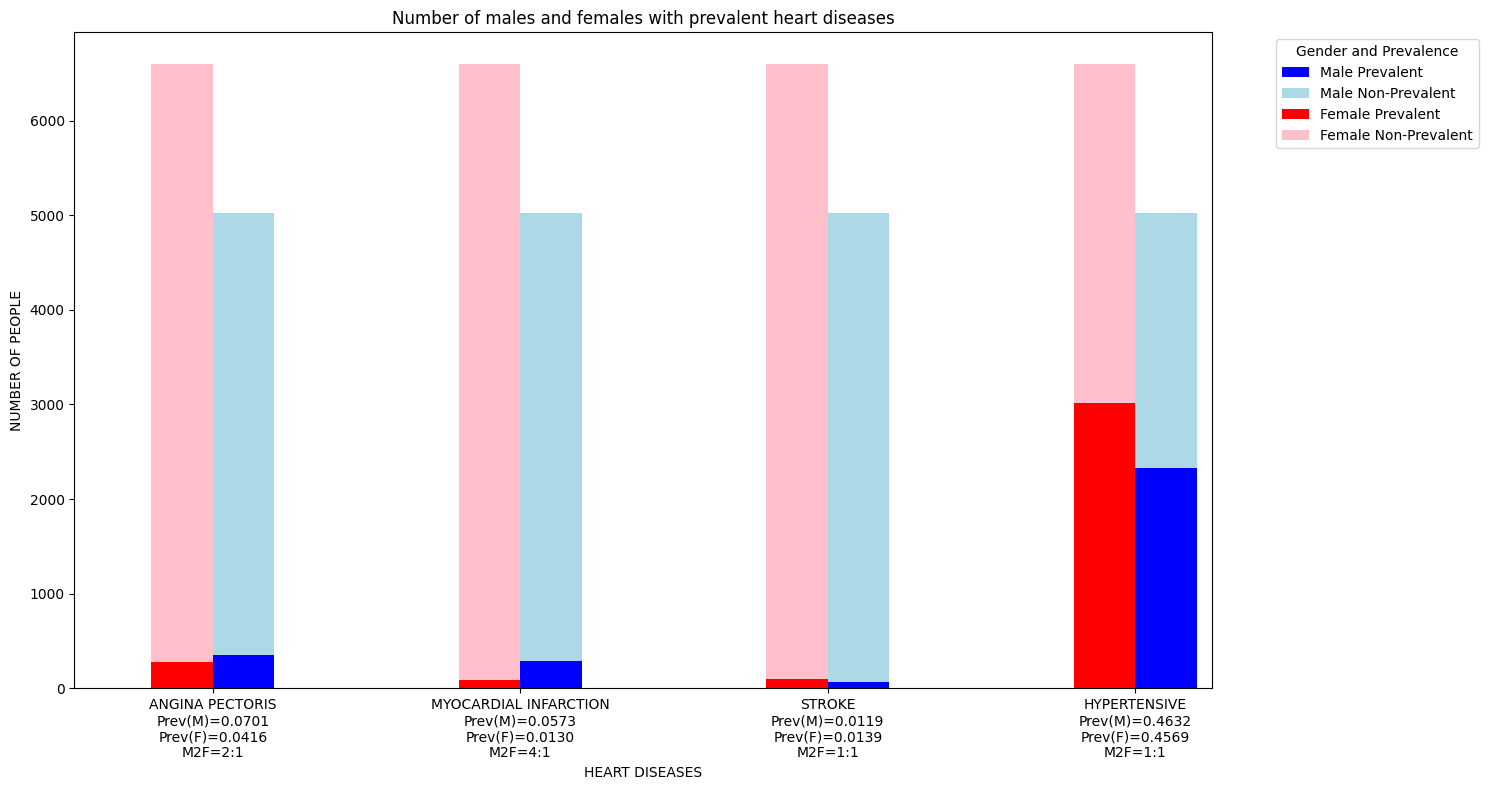

In [35]:
# Get data
male_prev, male_nonprev = [], []
female_prev, female_nonprev = [], []
for disease in heart_diseases:
    male_prev.append(len(df_full[ (df_full['SEX'] == 1) & (df_full[disease] == 1) ]))
    male_nonprev.append(len(df_full[ (df_full['SEX'] == 1) & (df_full[disease] == 0) ]))
    female_prev.append(len(df_full[ (df_full['SEX'] == 2) & (df_full[disease] == 1) ]))
    female_nonprev.append(len(df_full[ (df_full['SEX'] == 2) & (df_full[disease] == 0) ]))

# Calculate prevalence ratio + M2F
ratios = {x : [] for x in heart_diseases}
for disease, male_pos, male_neg, female_pos, female_neg in zip(heart_diseases, male_prev, male_nonprev, female_prev, female_nonprev):
    ratios[disease].append(male_pos/(male_pos + male_neg))
    ratios[disease].append(female_pos/(female_pos + female_neg))
m2f = ['2:1', '4:1', '1:1', '1:1']

# Sample dataset
data = {
    'Disease': [disease_dict[x].upper() + f"\nPrev(M)={ratios[x][0]:.4f}\nPrev(F)={ratios[x][1]:.4f}\nM2F={m2f[i]}" for i, x in enumerate(heart_diseases)],
    'Male_Prevalent': male_prev,
    'Male_Non_Prevalent': male_nonprev,
    'Female_Prevalent': female_prev,
    'Female_Non_Prevalent': female_nonprev
}
df = pd.DataFrame(data)

# Set the 'Disease' column as the index for plotting
df.set_index('Disease', inplace=True)

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(15, 8))
df[['Male_Prevalent', 'Male_Non_Prevalent']].plot(kind='bar', color=['blue', 'lightblue'], stacked=True, ax=ax, width=0.2, position=0)
df[['Female_Prevalent', 'Female_Non_Prevalent']].plot(kind='bar', color=['red', 'pink'], stacked=True, ax=ax, width=0.2, position=1)

# Add labels and titles
plt.xlabel('Heart Diseases'.upper())
plt.ylabel('Number of People'.upper())
plt.title('Number of males and females with prevalent heart diseases')

# Add a legend
plt.legend(['Male Prevalent', 'Male Non-Prevalent', 'Female Prevalent', 'Female Non-Prevalent'],
           title='Gender and Prevalence', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [36]:
pvalues, statistics = [], []
for disease in heart_diseases:
    # Construct the contigency table
    cont_table = pd.crosstab(index=df_full['SEX'], columns=df_full[disease])

    # Conduct the chi-square test
    statistic, pvalue, _, _ = stats.chi2_contingency(cont_table.values)
    statistics.append(statistic)
    pvalues.append(pvalue)

    # Report
    print('\n[INFO] Contigency test for ', disease_dict[disease])
    display(cont_table)
    print(f' - Chi-square statistic : {statistic}')
    print(f' - p-value : {pvalue}')

print(pd.DataFrame(
    {
        'Disease' : heart_diseases,
        '\chi^2-statistics' : statistics,
        'P-values' : pvalues
    }
).to_latex())



[INFO] Contigency test for  Angina Pectoris


PREVAP,0,1
SEX,,
1,4670,352
2,6330,275


 - Chi-square statistic : 44.72526756853998
 - p-value : 2.2671264947678908e-11

[INFO] Contigency test for  Myocardial Infarction


PREVMI,0,1
SEX,,
1,4734,288
2,6519,86


 - Chi-square statistic : 178.6394753885851
 - p-value : 9.604707307253907e-41

[INFO] Contigency test for  Stroke


PREVSTRK,0,1
SEX,,
1,4962,60
2,6513,92


 - Chi-square statistic : 0.7213196250242091
 - p-value : 0.3957113891051214

[INFO] Contigency test for  Hypertensive


PREVHYP,0,1
SEX,,
1,2696,2326
2,3587,3018


 - Chi-square statistic : 0.42185706879987944
 - p-value : 0.5160118546270585
\begin{tabular}{llrr}
\toprule
 & Disease & \chi^2-statistics & P-values \\
\midrule
0 & PREVAP & 44.725268 & 0.000000 \\
1 & PREVMI & 178.639475 & 0.000000 \\
2 & PREVSTRK & 0.721320 & 0.395711 \\
3 & PREVHYP & 0.421857 & 0.516012 \\
\bottomrule
\end{tabular}



# III. Survival analysis - First stroke after baseline exam
- Investigate how various cardiovascular risks affect the survival time of examined subjects.
- Does the use of anti-hypertensive pills affect the survival time of subjects.
- Investigate both Kaplan-Meier survival curves and Cox proportional hazards model.